## RecoGym -  Pure Organic vs Pure Bandit
#### Varying the number of online users

The purpose of this notebook is to show that a "Pure Organic" algorithm i.e. an algorithm that orders recommendations according to a next (organic) item prediction method is able to harness relatively plentiful organic data i.e. data the users provide themselves by organically interacting with the website.  Although the data is plentiful, it is only a proxy of the data of interest for making recommendations which is indeed bandit data.

In contrast a "Pure Bandit" algorithm receives feedback from the recommendations however it is only able to discover that poor recommendations are poor by trying them extensively and perorming poorly.


In [1]:
import numpy as np

import gym, reco_gym
import pandas as pd

from reco_gym import env_1_args, Configuration
from copy import deepcopy

env_1_args['random_seed'] = 5

# initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env_1_args['num_products'] = 80

In [2]:
env.init_gym(env_1_args)

# Create environments that differ only in the amount of noise "number of flips".
env_dict = {}
for f in (int(env.config.num_products * 2 / 8),):  # Number of flips (difference between organic and bandit behaviour).
    env_dict[f] = deepcopy(env)
    env_dict[f].generate_beta(f)

In [3]:
from agents import BanditCount, bandit_count_args
from agents import OrganicCount, organic_count_args

In [4]:
d_agent = {
    'Pure Organic': OrganicCount(Configuration({
        **organic_count_args,
        **env_1_args,
    })),
    'Pure Bandit': BanditCount(Configuration({
        **bandit_count_args,
        **env_1_args,
    })),
}

In [5]:
offline_organic = 10000
eval_size = 20000
l = list()
for samples in (1, 10, 100, 1000, 10000):
    for name in d_agent.keys():
        agent = d_agent[name]
        for f in env_dict.keys():
            c05, c0025, c0975 = reco_gym.test_agent(
                deepcopy(env_dict[f]),
                deepcopy(agent),
                samples,
                eval_size,
                offline_organic
            )
            df = {}
            df['agent'] = name
            df['training'] = samples
            df['ctr_05'] = [c05]
            df['ctr_0025'] = [c0025]
            df['ctr_0975'] = [c0975]
            df['flips'] = 'flips=%03d' % (f)
            df['f'] = f

            l.append(pd.DataFrame().from_dict(df))
res = pd.concat(l)

Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0
Starting Agent Training #0
Starting Agent Testing #0


In [6]:
# Enables the %%R magic.
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

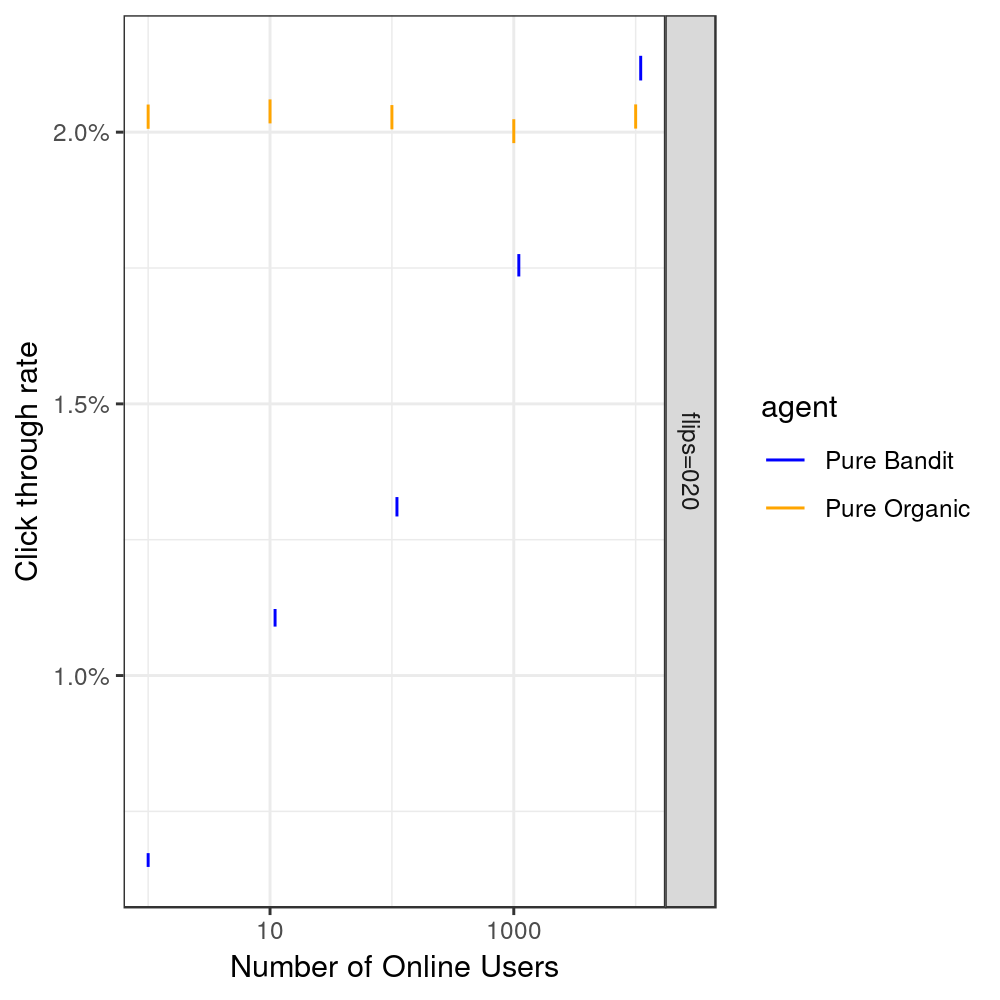

In [7]:
%%R -i res -w 5 -h 5 --units in -r 200
# Import df from global environment.
# Make default figure size 5 by 5 inches with 200 dpi resolution.

library(ggplot2)
library(data.table)
library(scales)
res<-data.table(res)
res[agent=='Pure Bandit',training:=1.1*training] # Dodge.

ggplot(res) + geom_errorbar(
    aes(x=training, ymin=ctr_0025, ymax=ctr_0975, colour=agent), width=0) +
    facet_grid(flips ~ .) +
    theme_bw() +
    ylab('Click through rate') +
    xlab('Number of Online Users') +
    scale_x_log10() +
    scale_y_continuous(labels=percent) +
    scale_colour_manual(values=c('blue', 'orange'))

We see that this plot reproduces the following prediction from our paper (with Pure Bandit and Pure Organic only):

“Pure Organic” behavior is de- termined by the amount of noise in $\sigma$ and is unaffected by the number of bandit events (this is not strictly true in the simulation and a small increase is evident on pure organic, as the user also provides an organic signal). If $\sigma$ is sufficiently small that the actions are correctly ordered it will perform well, in contrast if it is large it will perform poorly. The performance does not change as the number of bandit events increase as these are not used. In contrast the “Pure Bandit” algorithm is unable to make predictions without large numbers of bandit events. It performs poorly when this data is scarce and well when it is plentiful. 

<img src="images/section3_n_bandit_events.png" alt="Drawing" style="width: 650px;"/>